In [1]:
import numpy as np
from qiskit import IBMQ, assemble
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.jobstatus import JobStatus

In [2]:
import matplotlib.pyplot as plt
from qiskit import IBMQ, assemble
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.providers.jobstatus import JobStatus
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from qiskit.circuit.library import XXPlusYYGate

In [3]:
### parameterisation
from scipy.constants import h 
hbar = h/2*np.pi
U = 2
J = 1
dtau = -0.3*hbar/J

K_angle = dtau*J/hbar
c_phase_angle = -dtau*U/hbar

In [4]:
n = 16
circuit = QuantumCircuit(n,n)

In [5]:
# Set-up SqrtISWAP gate
sqrt2 = np.sqrt(2)
SqrtISWAP = Operator( [
    [1, 0, 0, 0],
    [0, 1/sqrt2, 1j/sqrt2, 0],
    [0, 1j/sqrt2, 1/sqrt2, 0],
    [0, 0, 0, 1] ])

# Create a Quantum Circuit acting on the q register 
n = 16
circuit = QuantumCircuit(n,n)

g_angles_up = [-1.530, -1.552, -1.541, -1.497, -1.214, -1.285, -0.311, -0.6168, -0.3738, -0.2199, -0.4508, -0.1271]
g_angles_down = [-1.370, -1.282, -1.213, -1.040, -1.087, -0.8378, -0.9723, -0.6613, -0.8592, -0.4833, -0.7414, -0.2856]

### Define function to add Givens rotaion to circuit
def addGivens(a, b, theta):
    circuit.unitary(SqrtISWAP, [a,b])
    circuit.rz(-theta, a)
    circuit.rz(theta, b)
    circuit.unitary(SqrtISWAP.transpose().conjugate(), [a,b])
        
def initialise(n0,q):
    circuit.x(n0)
    circuit.x(n0+1)
    addGivens(n0 + 1, n0 + 2, -1.53)
    addGivens(n0, n0 + 1, -1.552)
    addGivens(n0 + 2, n0 + 3, -1.541)
    addGivens(n0 + 1, n0 + 2, -1.497)
    addGivens(n0 + 3, n0 + 4, -1.214)
    addGivens(n0 + 2, n0 + 3, -1.285)
    addGivens(n0 + 4, n0 + 5, -0.311)
    addGivens(n0 + 3, n0 + 4, -0.6168)
    addGivens(n0 + 5, n0 + 6, -0.3738)
    addGivens(n0 + 4, n0 + 5, -0.2199)
    addGivens(n0 + 6, n0 + 7, -0.4508)
    addGivens(n0 + 5, n0 + 6, -0.1271)
    
def initialise1(n0,q):
    circuit.x(n0)
    circuit.x(n0+1)
    addGivens(n0 + 1, n0 + 2, -1.37)
    addGivens(n0, n0 +1, -1.282)
    addGivens(n0 + 2,n0+3,-1.213)
    addGivens(n0 + 1, n0 + 2, -1.040)
    addGivens(n0 + 3, n0 + 4, -1.087)
    addGivens(n0 + 2, n0 + 3, -0.8378)
    addGivens(n0 + 4, n0 + 5, -0.9723)
    addGivens(n0 + 3, n0 + 4, -0.6613)
    addGivens(n0 + 5, n0 + 6, -0.8592)
    addGivens(n0 + 4, n0 + 5, -0.4833)
    addGivens(n0 + 6, n0 + 7, -0.7414)
    addGivens(n0 + 5, n0 + 6, -0.2856)

initialise(0, 8)
initialise1(8, 8)


#circuit.draw('mpl')

In [6]:
def trotterstep():
    sqrt2 = np.sqrt(2)
    SqrtISWAP = Operator( [
        [1, 0, 0, 0],
        [0, 1/sqrt2, 1j/sqrt2, 0],
        [0, 1j/sqrt2, 1/sqrt2, 0],
        [0, 0, 0, 1] ])
    def addKGate(a,b,theta): 
        XXYYGate = XXPlusYYGate(2*theta,0) 
        circuit.append(XXYYGate, [a,b])
    def addCPHASE(a,b,theta): 
        circuit.cp(-theta,a,b)
        
    def addiSwap(a,b): 
        circuit.iswap(a,b) 
    
    # J odd 
    i=0 
    while i<n-1: 
        addKGate(i, i+1, K_angle) 
        i+=2 
        
    # U odd 
    i=0 
    while i<7: 
        addCPHASE(i, int(i + n/2),c_phase_angle)
        i+=2 
        
    # iSwap 
    i=1 
    while i<7: 
        addiSwap(i, i+1)
        i+=2 
    i=9 
    while i<14: 
        addiSwap(i, i+1) 
        i+=2 
    #U even
    i=2 
    while i<7: 
        addCPHASE(i, int(i + n/2), c_phase_angle) 
        i+=2 
    addCPHASE(7, 15, c_phase_angle) 
    # J even iSwap adjoint 
    i=1 
    while i<7: 
        addKGate(i, i+1,K_angle + (np.pi/2)) 
        i+=2 
    
    i=9 
    while i<14: 
        addKGate(i, i+1,K_angle + (np.pi/2)) 
        i+=2

trotterstep()
#print(K_angle)
#print(c_phase_angle)
#circuit.draw('mpl')

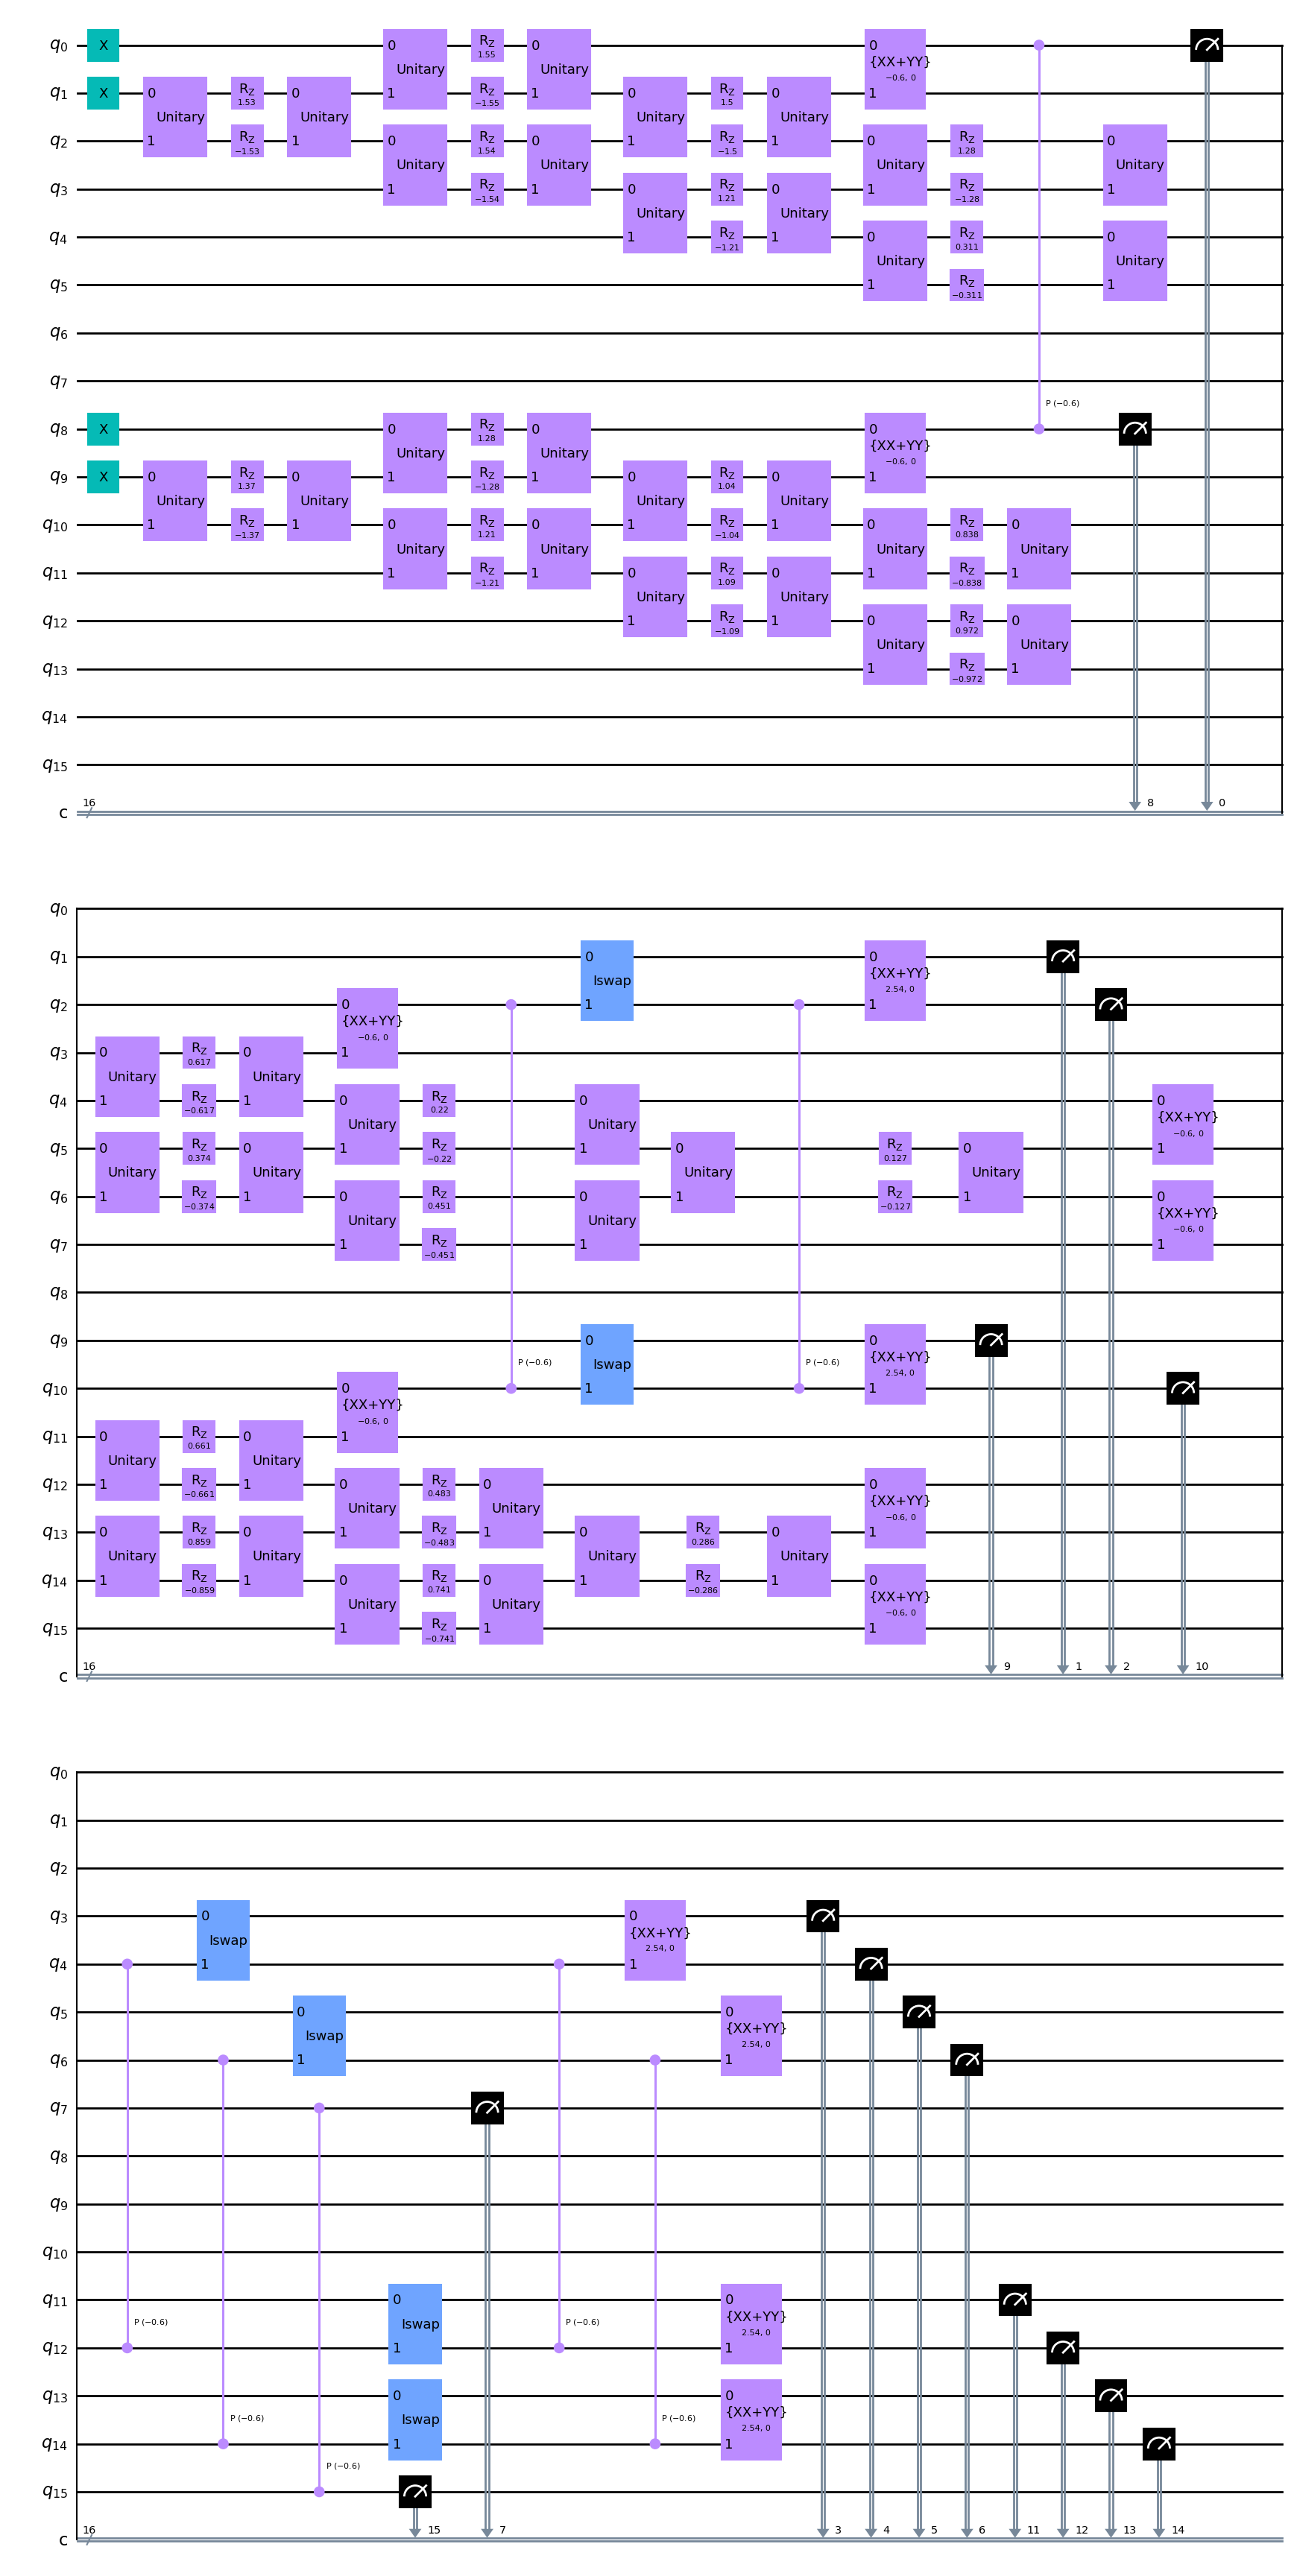

In [7]:
def takeMeasure(nmax):
    arr = list(range(0,nmax))
    circuit.measure(arr,arr)
    
takeMeasure(16)
circuit.draw('mpl')

In [8]:
allupdensity = np.zeros([11,8])
alldowndensity = np.zeros([11,8])

In [9]:
provider = IBMQ.save_account("ed5fdb9745e00ef1a0e87bfc75a7c1ffc61545cd826a2a530c01e1f5252c2057feb2f0cabdd18e23b9a28de8a8ea7d3d6de674246d8e78922dd7c855a1684d51")

provider = IBMQ.load_account()

backend = provider.backend.ibmq_belem

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

C:\Users\james\AppData\Local\Temp\ipykernel_19740\219164754.py:1: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = IBMQ.save_account("ed5fdb9745e00ef1a0e87bfc75a7c1ffc61545cd826a2a530c01e1f5252c2057feb2f0cabdd18e23b9a28de8a8ea7d3d6de674246d8e78922dd7c855a1684d51")
C:\Users\james\AppData\Local\Temp\ipykernel_19740\219164754.py:1: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.I

In [10]:
newresults = job.result().data()
#print(newresults)
allupdensity = np.zeros([11,8])
alldowndensity = np.zeros([11,8])

[0.1455  0.319   0.53475 0.993   0.997   0.551   0.32225 0.1375 ]
[-0.1425  -0.2905  -0.06175  0.4885   0.475   -0.0645  -0.27225 -0.132  ]


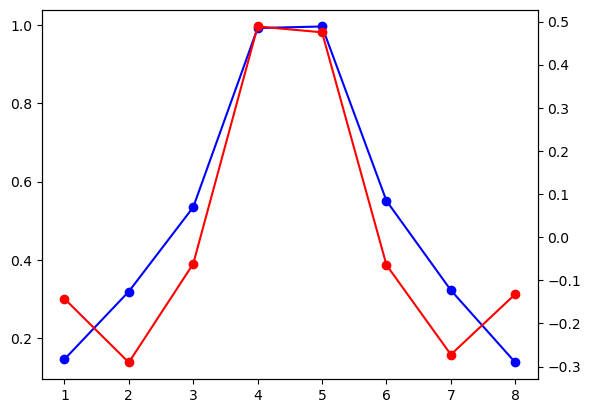

In [11]:
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[1] = upsitecount
alldowndensity[1] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

In [12]:
def initialise_circuit(circuit):
    occupied_orbitals = (0,1)
    up_circuit = SlaterDeterminant(up_transform[list])

[0.123   0.31125 0.5335  1.02875 1.036   0.5115  0.33625 0.11975]
[-0.1155  -0.29675 -0.1555   0.56275  0.538   -0.127   -0.29175 -0.11425]


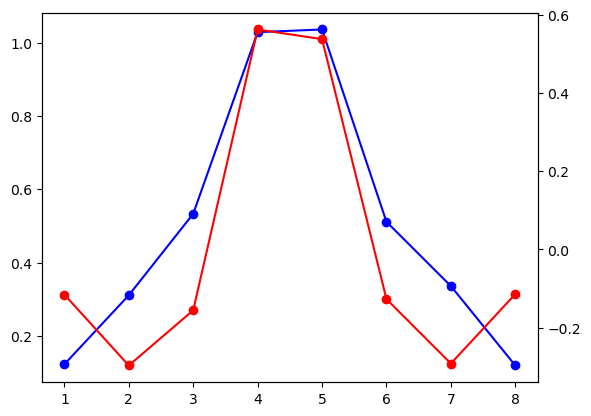

In [13]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 0

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

circuit.draw('mpl')
backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[0] = upsitecount
alldowndensity[0] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.13325 0.3395  0.5375  0.9955  0.9935  0.52175 0.33325 0.14575]
[-0.12975 -0.296   -0.0755   0.489    0.4845  -0.04925 -0.28325 -0.13975]


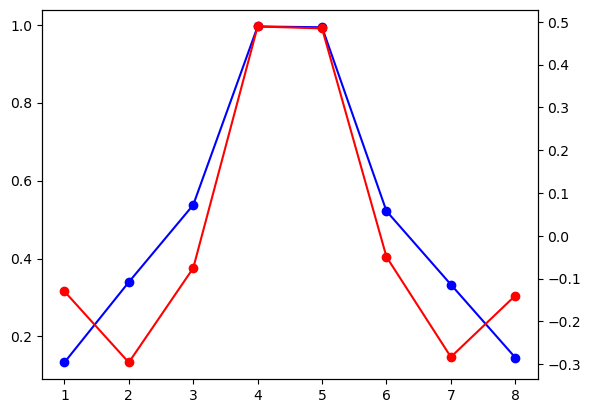

In [24]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 1

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

circuit.draw('mpl')
backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[0] = upsitecount
alldowndensity[0] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.1465  0.4265  0.60325 0.82275 0.8085  0.62225 0.4155  0.15475]
[-0.1465  -0.2465   0.00325  0.38275  0.384    0.02875 -0.258   -0.14775]


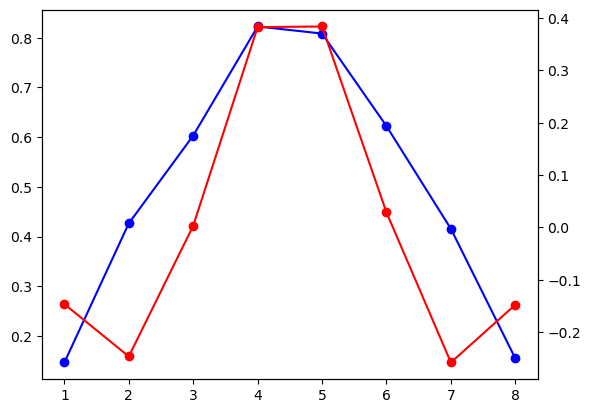

In [14]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 2

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

circuit.draw('mpl')
backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[2] = upsitecount
alldowndensity[2] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.17325 0.5985  0.6175  0.6095  0.616   0.62525 0.58925 0.17075]
[-0.15825 -0.21     0.097    0.2735   0.2595   0.12975 -0.24125 -0.15025]


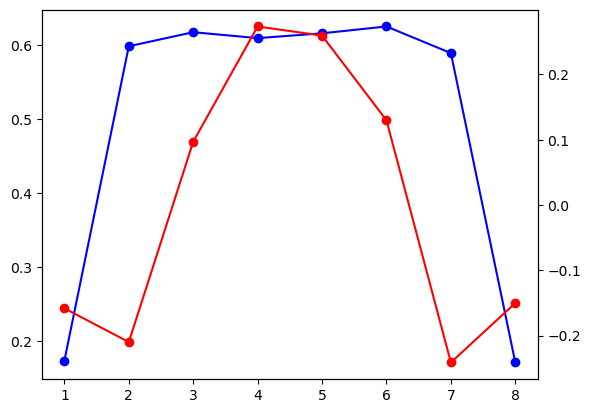

In [15]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 3

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[3] = upsitecount
alldowndensity[3] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.24475 0.7355  0.5165  0.495   0.48575 0.54275 0.7405  0.23925]
[-0.15725 -0.169    0.1535   0.1865   0.15025  0.20475 -0.2135  -0.15525]


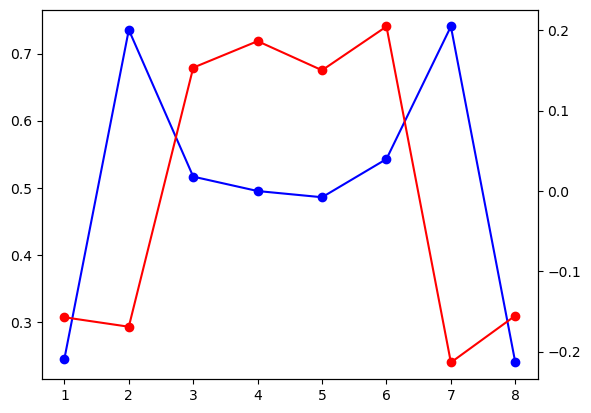

In [16]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 4

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[4] = upsitecount
alldowndensity[4] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.36025 0.7715  0.42    0.4335  0.424   0.43775 0.7995  0.3535 ]
[-0.13175 -0.133    0.156    0.104    0.0885   0.18775 -0.1325  -0.139  ]


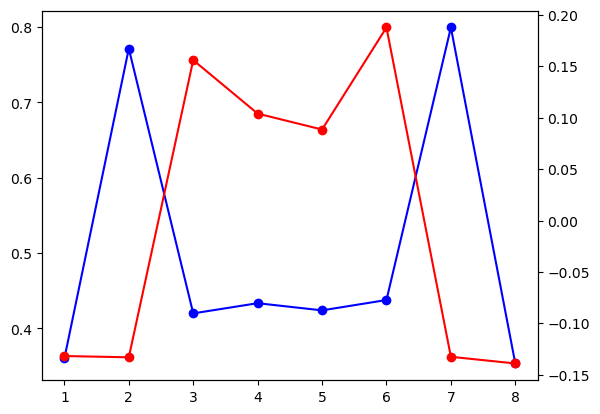

In [17]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 5

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[5] = upsitecount
alldowndensity[5] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.53175 0.684   0.41975 0.3775  0.36    0.4055  0.673   0.5485 ]
[-0.11075 -0.037    0.07175  0.076    0.064    0.081   -0.008   -0.137  ]


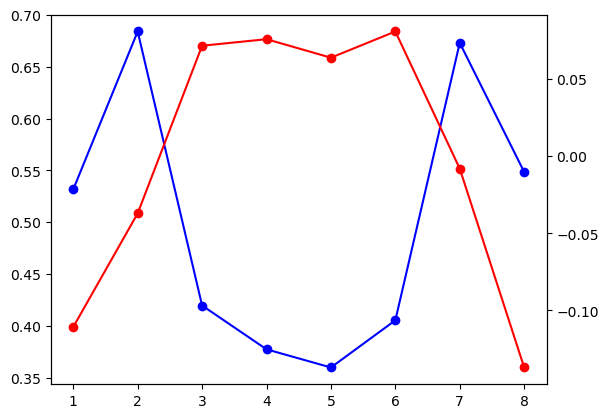

In [18]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 6

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[6] = upsitecount
alldowndensity[6] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.7015  0.5735  0.38375 0.3205  0.35275 0.3985  0.55025 0.71925]
[-0.0605  -0.002   -0.02025  0.0695   0.09425 -0.037    0.03675 -0.08075]


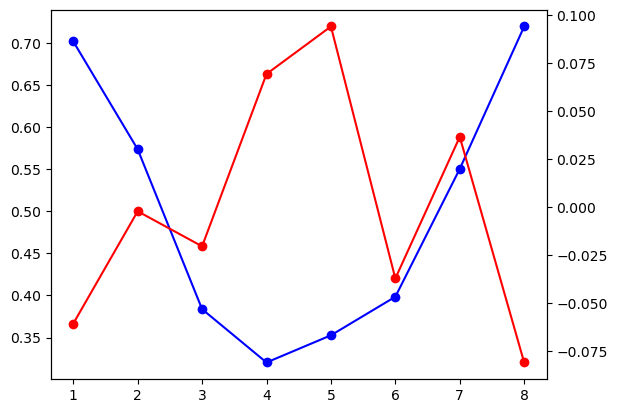

In [19]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 7

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[7] = upsitecount
alldowndensity[7] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.8095  0.49525 0.3795  0.31525 0.31425 0.3825  0.49375 0.81   ]
[-0.003   -0.04775 -0.0445   0.08725  0.09025 -0.088    0.01225 -0.0065 ]


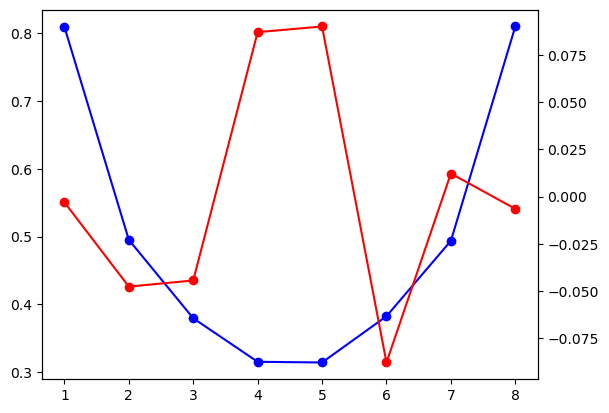

In [20]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 8

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)


updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[8] = upsitecount
alldowndensity[8] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.8155  0.4865  0.3865  0.30525 0.30325 0.4075  0.483   0.8125 ]
[ 0.106   -0.0995  -0.0845   0.07125  0.06225 -0.0885  -0.066    0.099  ]


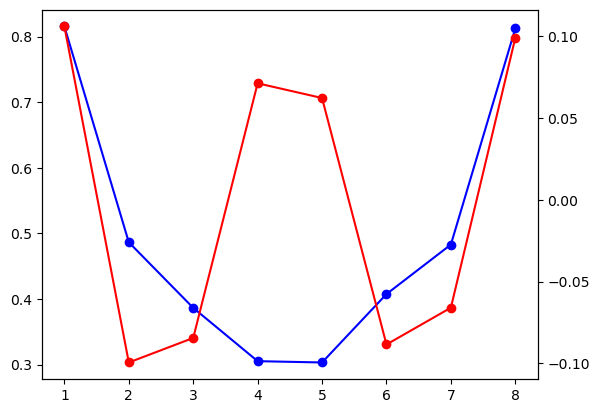

In [21]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 9

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[9] = upsitecount
alldowndensity[9] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

[0.71725 0.555   0.428   0.3125  0.30325 0.42475 0.54375 0.7155 ]
[ 0.20975 -0.1585  -0.1075   0.06     0.03525 -0.11225 -0.12725  0.2005 ]


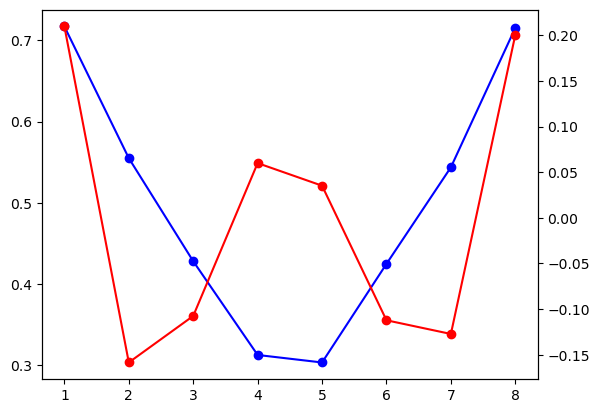

In [22]:
register = QuantumRegister(16)
classical = ClassicalRegister(16)
circuit = QuantumCircuit(register,classical)
initialise(0,8)
initialise1(8,8)

n_trotter = 10

j = 0
while(j<n_trotter):
    trotterstep()
    j += 1
    
takeMeasure(16)

backend = provider.backend.ibmq_qasm_simulator
transpiled = transpile(circuit, backend=backend)
job = backend.run(transpiled)
retrieved_job = backend.retrieve_job(job.job_id())

newresults = job.result().data()
upsitecount = np.zeros(8)
downsitecount = np.zeros(8)

for i in newresults['counts']:
    bitstr = bin(int(i,16))[2:].zfill(16)
    for j in range(len(upsitecount)):
        if bitstr[j] == '1':
            downsitecount[j] += newresults['counts'][i]
        if bitstr[j+8] == '1':
            upsitecount[j] += newresults['counts'][i]
            
upsitecount = upsitecount[::-1]
downsitecount = downsitecount[::-1]

upsitecount = upsitecount/4000
downsitecount = downsitecount/4000

x = np.arange(1,9,1)

updensity = np.zeros(8)
downdensity = np.zeros(8)

updensity = upsitecount + downsitecount
downdensity = upsitecount - downsitecount

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

allupdensity[10] = upsitecount
alldowndensity[10] = downsitecount

print(updensity)
print(downdensity)

ax1.plot(x, updensity, color='b', marker = 'o')
ax2.plot(x, downdensity, color='r', marker = 'o')
plt.show()

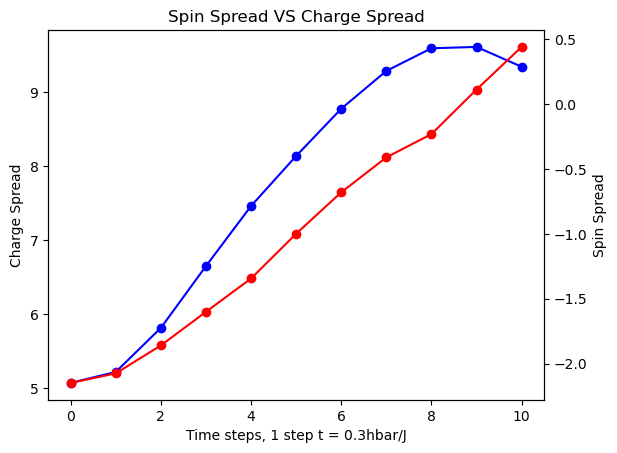

In [23]:
x = np.arange(1,3,0.3)

def kappavalues(a):
    mod1 = (np.sqrt(((1-(9/2))*a[0])**2))
    mod2 = (np.sqrt(((2-(9/2))*a[1])**2))
    mod3 = (np.sqrt(((3-(9/2))*a[2])**2))
    mod4 = (np.sqrt(((4-(9/2))*a[3])**2))
    mod5 = (np.sqrt(((5-(9/2))*a[4])**2))
    mod6 = (np.sqrt(((6-(9/2))*a[5])**2))
    mod7 = (np.sqrt(((7-(9/2))*a[6])**2))
    mod8 = (np.sqrt(((8-(9/2))*a[7])**2))
    arr = np.array([mod1,mod2,mod3,mod4,mod5,mod6,mod7,mod8])
    return np.sum(arr)

a1 = kappavalues(allupdensity[0])
a2 = kappavalues(allupdensity[1])
a3 = kappavalues(allupdensity[2])
a4 = kappavalues(allupdensity[3])
a5 = kappavalues(allupdensity[4])
a6 = kappavalues(allupdensity[5])
a7 = kappavalues(allupdensity[6])
a8 = kappavalues(allupdensity[7])
a9 = kappavalues(allupdensity[8])
a10 = kappavalues(allupdensity[9])
a11 = kappavalues(allupdensity[10])
plta = np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11])

b1 = kappavalues(alldowndensity[0])
b2 = kappavalues(alldowndensity[1])
b3 = kappavalues(alldowndensity[2])
b4 = kappavalues(alldowndensity[3])
b5 = kappavalues(alldowndensity[4])
b6 = kappavalues(alldowndensity[5])
b7 = kappavalues(alldowndensity[6])
b8 = kappavalues(alldowndensity[7])
b9 = kappavalues(alldowndensity[8])
b10 = kappavalues(alldowndensity[9])
b11 = kappavalues(alldowndensity[10])
pltb = np.array([b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11])

plta1 = plta + pltb
pltb1 = plta - pltb

fig,ax = plt.subplots()
ax.plot(plta1,color = 'b', marker = 'o')
plt.ylabel('Charge Spread')
plt.xlabel('Time steps, 1 step t = 0.3hbar/J')
ax2 = ax.twinx()
ax2.plot(pltb1,color = 'r', marker = 'o')
plt.title('Spin Spread VS Charge Spread')
plt.ylabel('Spin Spread')
plt.show()
